In [1]:
# Bayesian Binary logistic regression in 2d for iris flwoers

# Code is based on
# https://github.com/aloctavodia/BAP/blob/master/code/Chp4/04_Generalizing_linear_models.ipynb

%env MKL_THREADING_LAYER=GNU

try:
    import pymc as pm
except ModuleNotFoundError:
    %pip install mkl-service
    %pip install -qq pymc
    import pymc as pm
import numpy as np
import pandas as pd

try:
    import theano.tensor as tt
except ModuleNotFoundError:
    %pip install -qq theano
    import theano.tensor as tt
# import seaborn as sns
import scipy.stats as stats
from scipy.special import expit as logistic
import matplotlib.pyplot as plt

try:
    import arviz as az
except ModuleNotFoundError:
    %pip install -qq arviz
    import arviz as az
from sklearn.datasets import load_iris

try:
    from probml_utils import savefig, latexify, is_latexify_enabled
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import savefig, latexify, is_latexify_enabled

env: MKL_THREADING_LAYER=GNU


In [2]:
latexify(width_scale_factor=2, fig_height=1.75)

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


In [3]:
iris = load_iris()
X = iris.data
y = iris.target

# Convert to pandas dataframe
df_iris = pd.DataFrame(data=iris.data, columns=["sepal_length", "sepal_width", "petal_length", "petal_width"])
df_iris["species"] = pd.Series(iris.target_names[y], dtype="category")


df = df_iris.query("species == ('setosa', 'versicolor')")

# We reduce the sample size from 50 to 25 per class,
# or to 5 + 45 in the unbalanced setting.
# The latter will increase posterior uncertainty
unbalanced = True  # True
if unbalanced:
    df = df[45:95]
else:
    df = df[25:75]
assert len(df) == 50

In [4]:
y_1 = pd.Categorical(df["species"]).codes
x_n = ["sepal_length", "sepal_width"]
x_1 = df[x_n].values

In [5]:
with pm.Model() as model_1:
    α = pm.Normal("α", 0, 10)
    β = pm.Normal("β", 0, 2, shape=len(x_n))

    μ = α + pm.math.dot(x_1, β)
    θ = pm.Deterministic("θ", 1 / (1 + pm.math.exp(-μ)))
    bd = pm.Deterministic("bd", -α / β[1] - β[0] / β[1] * x_1[:, 0])

    yl = pm.Bernoulli("yl", p=θ, observed=y_1)

    trace_1 = pm.sample(2000, cores=1, chains=2)

varnames = ["α", "β"]
# az.plot_forest(trace_1, var_names=varnames);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [α, β]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 39 seconds.


In [6]:
bdsamples=np.array(trace_1['posterior']['bd'])
bdsamplesflatten = bdsamples.reshape(-1, bdsamples.shape[-1])

idx = np.argsort(x_1[:, 0])

# After modifying
# bd = trace_1["bd"].mean(0)[idx]

bd=bdsamplesflatten.mean(0)[idx]

/usr/local/lib/python3.7/dist-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


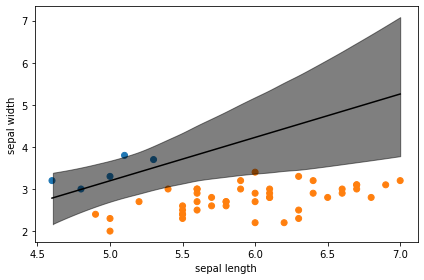

In [7]:
plt.figure()
plt.scatter(x_1[:, 0], x_1[:, 1], c=[f"C{x}" for x in y_1])
plt.plot(x_1[:, 0][idx], bd, color="k")

az.plot_hdi(x_1[:, 0], bdsamplesflatten, color="k")

plt.xlabel("sepal length")
plt.ylabel("sepal width")

plt.tight_layout()
if unbalanced:
    savefig("logreg_iris_bayes_2d_unbalanced", dpi=300)
else:
    savefig("logreg_iris_bayes_2d", dpi=300)

plt.show()